In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# 1D Radial Flow Problem

Grid Settings:

In [3]:
rw = 0.25 #ft
re = 1000 #ft
N = 4
height = 100 #ft

Rock and Fluid Properties:

In [4]:
perm = 50 #mD
poro = 0.2
visc = 5 #cp

Well Constraint:

In [5]:
qw = 5000 #ft3/day

Numerical Settings:

In [6]:
delta_time = 1 #day

Reservoir Initialization

In [7]:
pinit = 3000 #psi

Block Properties:

In [8]:
ct = 1e-5 #1/psi

## Gridding

In [9]:
gamma = (re/rw)**(1/N)
r0 = (rw*np.log(gamma)/(1-1/gamma)).tolist()
radius = r0*gamma**np.arange(-1,N+1)

In [10]:
radius

array([7.45577343e-02, 5.92935837e-01, 4.71544515e+00, 3.75005550e+01,
       2.98230937e+02, 2.37174335e+03])

## Array Calculations

In [11]:
def flow(gamma,deltat,deltaz,perm,visc):
    return (perm/visc*deltaz*deltat/np.log(gamma)).tolist()

In [12]:
def storage(radius,deltat,deltaz,poro,delta_time):
    lhs = (poro*deltat*deltaz)/(2*delta_time)
    gamma = radius[1]/radius[0]
    radius = np.asarray(radius)
    rhs = (radius[2:]**2-2*radius[1:-1]**2+radius[:-2]**2)/(2*np.log(gamma))
    return lhs*rhs

In [13]:
t = flow(gamma,2*np.pi,height,perm,visc)*1.06235016e-14/1.4503774389728e-7*24*60*60

In [14]:
t

19.176688949192048

In [15]:
a = storage(radius,2*np.pi,height,poro,delta_time)

In [16]:
a

array([3.26321208e+02, 2.06383653e+04, 1.30528483e+06, 8.25534612e+07])

## Array Assembly

In [17]:
T = np.zeros((N,N))
A = np.zeros((N,N))
Q = np.zeros((N,1))
P = np.ones((N,1))*pinit

In [18]:
for i in range(N):
    if i>0:
        T[i,i-1] = -t
        T[i,i] += t
    if i<N-1:
        T[i,i+1] = -t
        T[i,i] += t
        
A = np.diag(a*ct)

Q[0] = -5000

In [19]:
T

array([[ 19.17668895, -19.17668895,   0.        ,   0.        ],
       [-19.17668895,  38.3533779 , -19.17668895,   0.        ],
       [  0.        , -19.17668895,  38.3533779 , -19.17668895],
       [  0.        ,   0.        , -19.17668895,  19.17668895]])

In [20]:
A

array([[3.26321208e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.06383653e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.30528483e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.25534612e+02]])

In [21]:
Q

array([[-5000.],
       [    0.],
       [    0.],
       [    0.]])

In [22]:
P

array([[3000.],
       [3000.],
       [3000.],
       [3000.]])

In [23]:
for index in range(3):
    P = np.linalg.solve(T+A,np.dot(A,P)+Q)
    print(f"For time step {index}:\n",P)

For time step 0:
 [[2328.6559027 ]
 [2589.27489042]
 [2845.47356613]
 [2996.4919312 ]]
For time step 1:
 [[2257.03040039]
 [2517.75143957]
 [2777.70272798]
 [2991.52496499]]
For time step 2:
 [[2225.57066106]
 [2486.29853506]
 [2746.68790614]
 [2985.96665872]]


## General Solution

In [24]:
def solver(rw,re,N,days):
    
    gamma = (re/rw)**(1/N)
    r0 = (rw*np.log(gamma)/(1-1/gamma)).tolist()
    radius = r0*gamma**np.arange(-1,N+1)

    t = flow(gamma,2*np.pi,height,perm,visc)*1.06235016e-14/1.4503774389728e-7*24*60*60
    a = storage(radius,2*np.pi,height,poro,delta_time)

    T = np.zeros((N,N))
    A = np.zeros((N,N))
    Q = np.zeros((N,1))
    P = np.ones((N,1))*pinit

    for i in range(N):
        if i>0:
            T[i,i-1] = -t
            T[i,i] += t
        if i<N-1:
            T[i,i+1] = -t
            T[i,i] += t
            
    A = np.diag(a*ct)
    
    Q[0] = -5000

    for index in range(days):
        P = np.linalg.solve(T+A,np.dot(A,P)+Q)
        
    return radius,P

### Pressure Distribution for Constant Flow Rate Well and Bounded (No-Flux) Reservoir

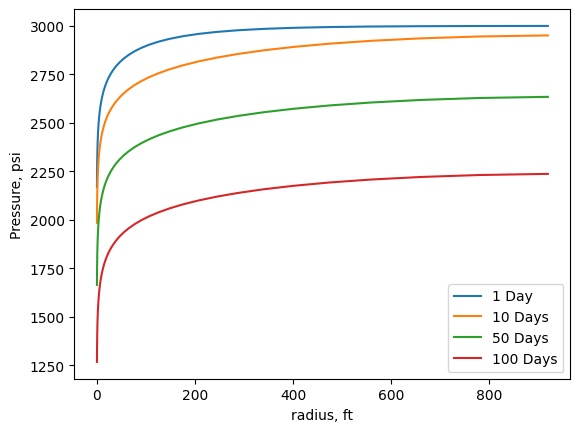

In [39]:
radius1,pressure1 = solver(0.25,1000,50,1)
radius2,pressure2 = solver(0.25,1000,50,10)
radius3,pressure3 = solver(0.25,1000,50,50)
radius4,pressure4 = solver(0.25,1000,50,100)

plt.plot(radius1[1:-1],pressure1,label="1 Day")
plt.plot(radius2[1:-1],pressure2,label="10 Days")
plt.plot(radius3[1:-1],pressure3,label="50 Days")
plt.plot(radius4[1:-1],pressure4,label="100 Days")

plt.xlabel("radius, ft")
plt.ylabel("Pressure, psi")

plt.legend()

plt.show()